<a href="https://colab.research.google.com/github/zeesh-ali/Chest-Xray-Classification/blob/master/Chest_Xray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chest X-Ray Classification:

Objective: To classifiy chest X-Ray in order to identify Pneumonia for diagonosis

Source: Kaggle Pneumonia X-Ray Image Dataset https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import matplotlib.image as mpimg
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

In [0]:
#Uploading the kaggle.json file for connecting to the kaggle datasets
from google.colab import files
files.upload()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!ls -lrt ~/.kaggle

total 4
-rw------- 1 root root 64 Sep 28 20:54 kaggle.json


In [12]:
#Dowload dataset directly from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:40<00:00, 26.9MB/s]
100% 2.29G/2.29G [00:40<00:00, 60.8MB/s]


In [193]:
!ls -lrt

total 2405648
drwxr-xr-x 1 root root       4096 Aug 27 16:17 sample_data
-rw-r--r-- 1 root root         64 Sep 28 20:52 kaggle.json
-rw-r--r-- 1 root root 2463365435 Sep 28 20:55 chest-xray-pneumonia.zip
drwxr-xr-x 7 root root       4096 Sep 28 21:16 chest_xray


In [29]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [194]:
print("\nTest Data Images Count")
print("Test Normal")
!ls -lrt chest_xray/test/NORMAL/ | wc -l
print("Test Pneumonia")
!ls -lrt chest_xray/test/PNEUMONIA// | wc -l
print("\nTrain Data Images Count")
print("Train Normal")
!ls -lrt chest_xray/train/NORMAL/ | wc -l
print("Train Pneumonia")
!ls -lrt chest_xray/train/PNEUMONIA/ | wc -l
print("\nVal Data Images Count ")
print("Val Normal")
!ls -lrt chest_xray/val/NORMAL/ | wc -l
print("Val Pneumonia")
!ls -lrt chest_xray/val/PNEUMONIA/  | wc -l


Test Data Images Count
Test Normal
235
Test Pneumonia
391

Train Data Images Count
Train Normal
1342
Train Pneumonia
3876

Val Data Images Count 
Val Normal
9
Val Pneumonia
9


In [0]:
#Setting Directories 
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"
val_dir = "/content/chest_xray/val"
categories = ['NORMAL','PNEUMONIA']

In [0]:
def plot_images(path):
  cnt=0  
  
  fig = plt.figure(figsize=(12, 6))
 
  for file in os.listdir(path):
      print(file)
      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(221+cnt)
      plt.imshow(img, cmap='bone')
      cnt=cnt+1
      if cnt == 4:
        break

NORMAL2-IM-0815-0001.jpeg
IM-0481-0001.jpeg
NORMAL2-IM-0535-0001-0002.jpeg
IM-0672-0001.jpeg


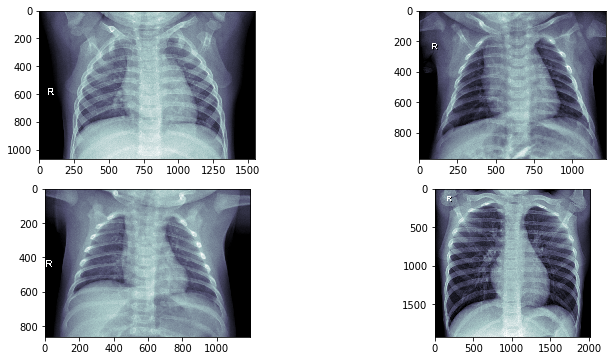

In [196]:
plot_images(train_dir + '/NORMAL')

person1429_bacteria_3691.jpeg
person899_virus_1553.jpeg
person516_virus_1033.jpeg
person1295_virus_2223.jpeg


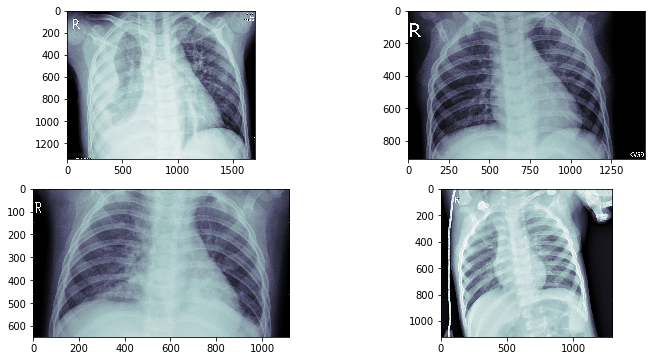

In [197]:
plot_images(train_dir + '/PNEUMONIA')

In [199]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 20
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='sigmoid')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [209]:
model = get_model()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_734 (Conv2D)             (None, None, None, 3 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_741 (BatchN (None, None, None, 3 96          conv2d_734[0][0]                 
__________________________________________________________________________________________________
activation_733 (Activation)     (None, None, None, 3 0           batch_normalization_741[0][0]    
____________________________________________________________________________________________

In [210]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/5
261/261 [==============================] - 391s 1s/step - loss: 0.4985 - acc: 0.8415 - val_loss: 0.4860 - val_acc: 0.7500
Epoch 2/5
261/261 [==============================] - 374s 1s/step - loss: 0.2792 - acc: 0.8876 - val_loss: 0.7784 - val_acc: 0.5000
Epoch 3/5
261/261 [==============================] - 376s 1s/step - loss: 0.2761 - acc: 0.8928 - val_loss: 0.7504 - val_acc: 0.6875
Epoch 4/5
261/261 [==============================] - 375s 1s/step - loss: 0.2564 - acc: 0.9041 - val_loss: 1.0686 - val_acc: 0.6250
Epoch 5/5
261/261 [==============================] - 372s 1s/step - loss: 0.2661 - acc: 0.8929 - val_loss: 0.9701 - val_acc: 0.6250


In [211]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1, use_multiprocessing=True)
print('Model Loss:', result[0])
print('Model Accuracy:', result[1])

624/624 [==============================] - 70s 112ms/step
Model Loss: 0.5809186266948624
Model Accuracy: 0.7323717948717948


In [212]:
y_pred_batches = []
y_true_batches = []
y_img_batches=[]
for i in range(0, len(test_generator)):
  y_img_batch,y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),

In [0]:
def predict_images(images_path, label):
  cnt=0
  fig = plt.figure(figsize=(16, 6))

  for file in os.listdir(images_path):
  
      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+cnt)
      plt.title('{}=> Pred: {}'.format(label, 'NORMAL' if y_pred_batches[cnt] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img,cmap='bone')
      cnt=cnt+1
    

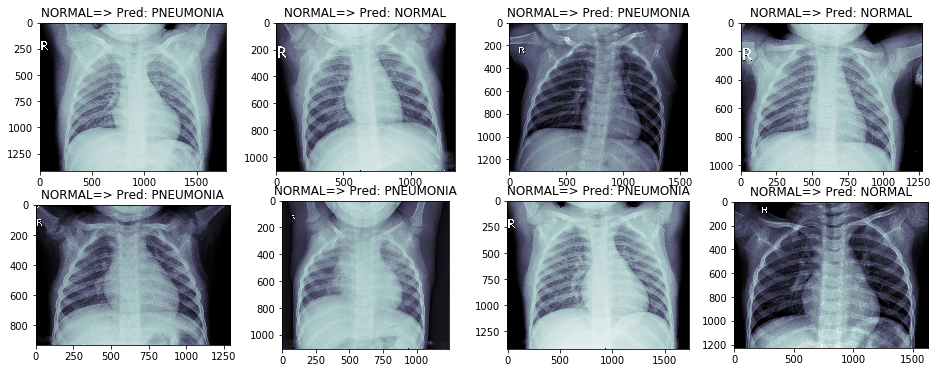

In [224]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

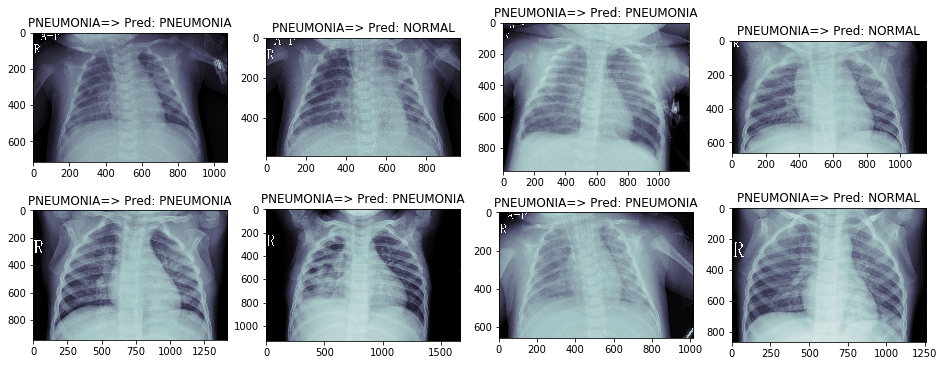

In [225]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')